In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PyAddgals.config import parseConfig
from PyAddgals.cosmology import Cosmology
from PyAddgals.domain import Domain
from PyAddgals.nBody import NBody
from PyAddgals.addgalsModel import ADDGALSModel
import PyAddgals.config as config_mod
from PyAddgals.kcorrect import KCorrect, k_reconstruct_maggies


import fitsio

In [2]:
config_file = '../data/addgals_sdss.cfg'

config = parseConfig(config_file)

comm = None

cc = config['Cosmology']
nb_config = config['NBody']

cosmo = Cosmology(**cc)

domain = Domain(cosmo, **nb_config.pop('Domain'))
domain.decomp(comm, 0, 1)

for d in domain.yieldDomains():
    nbody = NBody(cosmo, d, **nb_config)
    break

model = ADDGALSModel(nbody, **config['GalaxyModel']['ADDGALSModel'])

/usr/local/lib/python3.7/dist-packages/pyaddgals-1.0-py3.7.egg/PyAddgals/config.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(fp)


[0]: fit       fun: 110.4807501177961
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.49514077e-06, -5.72071440e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 12
   status: 0
  success: True
        x: array([-2.32924221, -2.32158503])
[0]: fit       fun: -1140.4921643165346
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.25188905e-05,  1.77867940e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 12
   status: 0
  success: True
        x: array([-2.02755141, -1.57427751])
[0]: fit       fun: -1267.867260494131
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.53569963e-07,  5.77876563e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 12
   status: 0
  success: True
        x: array([-4.06535248, -0.7944941 ])
[0]: fit       fun: -41.09275933548224
 hess_inv: <2x2 LbfgsIn

In [10]:
#create a kcorrect object, that knows how to compute fluxes from a set of templates and kcorrect coefficients
#right now, we use a default set of templates, but modifying emission lines will just be a matter
#of adding to and augmenting these templates
kcorr = KCorrect(template_name='default')


In [15]:
fitsio.write('../data/z.fits', z[::100], clobber=True)
fitsio.write('../data/sed_id.fits', sed_idx[::100], clobber=True)
fitsio.write('../data/mag_r.fits', mag[::100], clobber=True)

In [16]:
#get kcorrect coefficients
z = fitsio.read('../data/z.fits')
sed_idx = fitsio.read('../data/sed_id.fits')
mag = fitsio.read('../data/mag_r.fits')

coeffs = model.colorModel.trainingSet[sed_idx]['COEFFS']


In [11]:
# calculate sdss r band absolute magnitude in order
# to renormalize the kcorrect coefficients to give
# the correct absolute magnitudes for the simulated
# galaxies
sdss_r_name = ['sdss/sdss_r0.par']
filter_lambda, filter_pass = kcorr.load_filters(sdss_r_name)

rmatrix = kcorr.k_projection_table(filter_pass, filter_lambda, [0.1])
rmatrix0 = kcorr.k_projection_table(filter_pass, filter_lambda, [0.0])

amag = k_reconstruct_maggies(rmatrix.astype(np.float64),
                             coeffs.astype(np.float64),
                             np.zeros_like(z).astype(np.float64),
                             kcorr.zvals.astype(np.float64))

omag = k_reconstruct_maggies(rmatrix0.astype(np.float64),
                             coeffs.astype(np.float64),
                             z.astype(np.float64),
                             kcorr.zvals.astype(np.float64))

#k correction
kc = 2.5 * np.log10(amag / omag)

#compute distance modulus in order to get absolute magnitude
a = 1 / (1 + z)
amax = 1 / (1 + 1e-7)
a[a > amax] = amax

omag = -2.5 * np.log10(omag)
dm = nbody.cosmo.distanceModulus(1 / a - 1)
amag = omag - dm.reshape(-1, 1) - kc

# renormalize coeffs to sum to correct absolute magnitude
coeffs *= 10 ** ((mag.reshape(-1, 1) - amag) / -2.5)



In [12]:
# Calculate observed and absolute magnitudes in desired bands
# For this example, we'll use the DES filters

filters = ['desy3/desy3std_g.par', 'desy3/desy3std_r.par',
           'desy3/desy3std_i.par', 'desy3/desy3std_z.par',
           'desy3/desy3_Y.par']

filter_lambda, filter_pass = kcorr.load_filters(filters)

# precompute integrals over bandpasses at grid of redshifts 
# in order to speed up calculation of fluxes for arbitrary
# sets of coefficients
rmatrix0 = kcorr.k_projection_table(filter_pass, filter_lambda,
                                    [0.0] * len(filters))
rmatrix = kcorr.k_projection_table(filter_pass, filter_lambda,
                                   model.colorModel.band_shift)

# compute "rest" frame flux (actual frame specified by band_shift parameter)
aflux = k_reconstruct_maggies(rmatrix,
                             coeffs.astype(np.float64),
                             np.zeros_like(z).astype(np.float64),
                             kcorr.zvals)

# compute observed flux
oflux = k_reconstruct_maggies(rmatrix0,
                             coeffs.astype(np.float64),
                             z.astype(np.float64),
                             kcorr.zvals)

kc = 2.5 * np.log10(amag / omag)
omag = -2.5 * np.log10(oflux)
amag = omag - dm.reshape(-1, 1) - kc


Text(0, 0.5, '$n(\\rm mag)$')

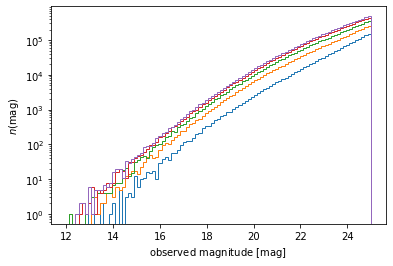

In [13]:
for i in range(omag.shape[1]):
    plt.hist(omag[:,i], np.linspace(12,25,100), histtype='step')

plt.yscale('log')
plt.xlabel(r'observed magnitude $[\rm mag]$')
plt.ylabel(r'$n(\rm mag)$')